# Covariance v Coherence

In [1]:
import os
import sys

# import h5py
# from IPython.display import HTML, display
import numpy as np

# from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

# from scipy.fft import ifft
# import scipy.signal as ss
# import scipy.linalg as sl
# from sklearn.utils.extmath import randomized_svd
import time

# sys.path.append('../')
sys.path.append(os.path.join(os.path.dirname(""), os.pardir))
import coherence_analysis.utils as f

In [2]:
fsize = 15

samples_per_sec = 1000
subwindow_len = 1
overlap = 0

start_ch = 3100
nchannels = 2000
nsensors = 200

In [3]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083848.h5"
data, _ = f.load_brady_hdf5(file, normalize="no")

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083918.h5"
data2, _ = f.load_brady_hdf5(file, normalize="no")

data = np.append(data, data2, axis=1)
# data = np.append(data3,data,axis=1)

In [4]:
t0 = time.time()
coherence_big_event, frequencies = f.welch_coherence(
    data[start_ch : nchannels + start_ch : int(nchannels / nsensors)],
    subwindow_len,
    overlap,
    sample_interval=0.001,
)
t1 = time.time()
coherence_time = t1 - t0

t0 = time.time()
preprocessed_data = f.covariance_preprocessing(data[start_ch : nchannels + start_ch : int(nchannels / nsensors)], sample_interval=1/samples_per_sec)
covariance, frequencies = f.covariance(
    preprocessed_data,
    subwindow_len,
    overlap,
    sample_interval=0.001,
)
t1 = time.time()
covariance_time = t1 - t0

print(f"Coherence time: {coherence_time}")
print(f"Covariance time: {covariance_time}")

Coherence time: 12.026422023773193
Covariance time: 11.638254880905151


In [5]:
num_frames = coherence_big_event.shape[0]
eig_ratios_coherence = np.empty(num_frames)
eig_ratios_covariance = np.empty(num_frames)

t0 = time.time()
for d in range(num_frames):
    # eigenvals, _ = np.linalg.eig(coherence_big_event[d])
    eigenvals = np.linalg.eigvalsh(coherence_big_event[d])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios_coherence[d] = eigenvals[0] / np.sum(eigenvals)
t1 = time.time()
coherence_time += t1 - t0

t0 = time.time()
for d in range(num_frames):
    # eigenvals, _ = np.linalg.eig(covariance[d])
    eigenvals = np.linalg.eigvalsh(covariance[d])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios_covariance[d] = eigenvals[0] / np.sum(eigenvals)
t1 = time.time()
covariance_time += t1 - t0

print(f"Coherence time: {coherence_time}")
print(f"Covariance time: {covariance_time}")

Coherence time: 13.845485925674438
Covariance time: 18.48061227798462


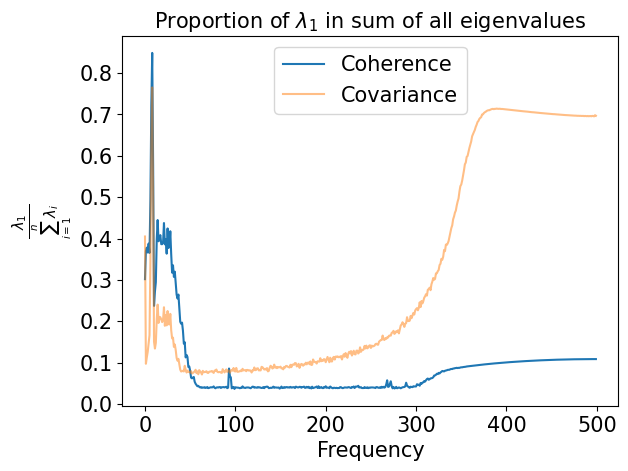

In [13]:
frequency_extent_ind = -1
plt.plot(
    frequencies[:frequency_extent_ind],
    eig_ratios_coherence[:frequency_extent_ind],
    label="Coherence",
)
plt.plot(
    frequencies[:frequency_extent_ind],
    eig_ratios_covariance[:frequency_extent_ind],
    label="Covariance",
    alpha=0.5,
)
plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.title(
    "Proportion of $\lambda_1$ in sum of all eigenvalues", fontsize=fsize
)
plt.legend(fontsize=fsize)

## Using SVD

In [25]:
t0 = time.time()
norm_win_spectra, frequencies = f.normalised_windowed_spectra(
    data[start_ch : nchannels + start_ch : int(nchannels / nsensors)],
    subwindow_len,
    overlap,
    sample_interval=0.001,
)
t1 = time.time()
coherence_time = t1 - t0

t0 = time.time()
preprocessed_data = f.covariance_preprocessing(data[start_ch : nchannels + start_ch : int(nchannels / nsensors)], sample_interval=1/samples_per_sec)
win_spectra, frequencies = f.windowed_spectra(
    preprocessed_data,
    subwindow_len,
    overlap,
    freq=None,
    sample_interval=0.001,
)
win_spectra = win_spectra.transpose(2, 1, 0)
# win_spectra = win_spectra/np.sqrt(win_spectra.shape[2])
t1 = time.time()
covariance_time = t1 - t0

print(f"Coherence time: {coherence_time}")
print(f"Covariance time: {covariance_time}")

Coherence time: 1.1109998226165771
Covariance time: 2.187948703765869


In [26]:
num_frames = coherence_big_event.shape[0]
eig_ratios_coherence = np.empty(num_frames)
eig_ratios_covariance = np.empty(num_frames)

t0 = time.time()
for d in range(num_frames):
    # U, S, Vh = np.linalg.svd(norm_win_spectra[d])
    S = np.linalg.svd(
            norm_win_spectra[d],
            compute_uv=False,
            hermitian=False,
        )
    svd_approx = S**2
    # svd_approx2 = np.sort(S)[::-1]**2
    eig_ratios_coherence[d] = np.max(svd_approx) / np.sum(svd_approx)
t1 = time.time()
coherence_time += t1 - t0

t0 = time.time()
for d in range(num_frames):
    # U, S, Vh = np.linalg.svd(win_spectra[d])
    S = np.linalg.svd(
            win_spectra[d],
            compute_uv=False,
            hermitian=False,
        )
    svd_approx2 = S**2
    # svd_approx2 = np.sort(S)[::-1]**2
    eig_ratios_covariance[d] = np.max(svd_approx2) / np.sum(svd_approx2)
t1 = time.time()
covariance_time += t1 - t0

print(f"Coherence time: {coherence_time}")
print(f"Covariance time: {covariance_time}")

Coherence time: 5.033592462539673
Covariance time: 5.926995515823364


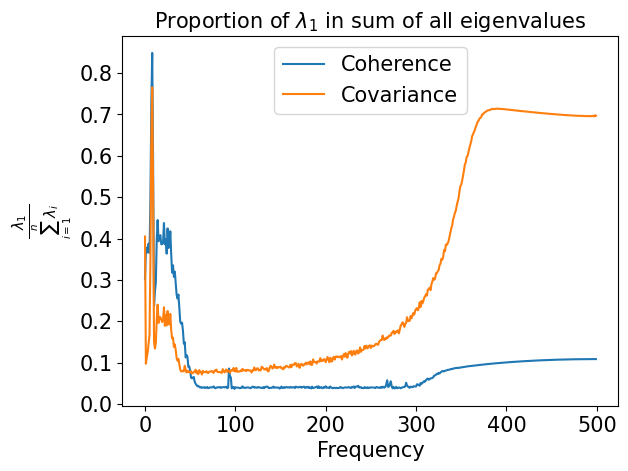

In [27]:
frequency_extent_ind = -1
plt.plot(
    frequencies[:frequency_extent_ind],
    eig_ratios_coherence[:frequency_extent_ind],
    label="Coherence",
)
plt.plot(
    frequencies[:frequency_extent_ind],
    eig_ratios_covariance[:frequency_extent_ind],
    label="Covariance",
)
plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.title(
    r"Proportion of $\lambda_1$ in sum of all eigenvalues", fontsize=fsize
)
plt.legend(fontsize=fsize)

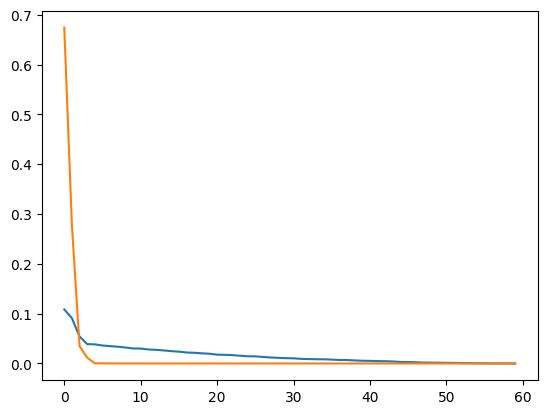

In [12]:
plt.plot(svd_approx / np.sum(svd_approx))
plt.plot(svd_approx2 / np.sum(svd_approx2))

In [14]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000018.h5"
data_noise, _ = f.load_brady_hdf5(file, normalize="no")

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000048.h5"
data_noise2, _ = f.load_brady_hdf5(file, normalize="no")

data_noise = np.append(data_noise, data_noise2, axis=1)

In [15]:
t0 = time.time()
norm_win_spectra_noise, frequencies = f.normalised_windowed_spectra(
    data_noise[start_ch : nchannels + start_ch : int(nchannels / nsensors)],
    subwindow_len,
    overlap,
    sample_interval=0.001,
)
t1 = time.time()
coherence_time = t1 - t0

t0 = time.time()
preprocessed_data_noise = f.covariance_preprocessing(data_noise[start_ch : nchannels + start_ch : int(nchannels / nsensors)], sample_interval=1/samples_per_sec)
win_spectra_noise, frequencies = f.windowed_spectra(
    preprocessed_data_noise,
    subwindow_len,
    overlap,
    freq=None,
    sample_interval=0.001,
)
win_spectra_noise = win_spectra_noise.transpose(2, 1, 0)
t1 = time.time()
covariance_time = t1 - t0

print(f"Coherence time: {coherence_time}")
print(f"Covariance time: {covariance_time}")

Coherence time: 1.8056354522705078
Covariance time: 3.6997432708740234


In [16]:
num_frames = win_spectra_noise.shape[0]
eig_ratios_coherence_noise = np.empty(num_frames)
eig_ratios_covariance_noise = np.empty(num_frames)

t0 = time.time()
for d in range(num_frames):
    # U, S, Vh = np.linalg.svd(norm_win_spectra_noise[d])
    S = np.linalg.svd(
            norm_win_spectra_noise[d],
            compute_uv=False,
            hermitian=False,
        )
    svd_approx2 = S**2
    # svd_approx2 = np.sort(S)[::-1]**2
    eig_ratios_coherence_noise[d] = np.max(svd_approx2) / np.sum(svd_approx2)
t1 = time.time()
coherence_time += t1 - t0

t0 = time.time()
for d in range(num_frames):
    # U, S, Vh = np.linalg.svd(win_spectra_noise[d])
    S = np.linalg.svd(
            win_spectra_noise[d],
            compute_uv=False,
            hermitian=False,
        )
    svd_approx2 = S**2
    # svd_approx2 = np.sort(S)[::-1]**2
    eig_ratios_covariance_noise[d] = np.max(svd_approx2) / np.sum(svd_approx2)
t1 = time.time()
covariance_time += t1 - t0

print(f"Coherence time: {coherence_time}")
print(f"Covariance time: {covariance_time}")

Coherence time: 6.3027002811431885
Covariance time: 7.65401291847229


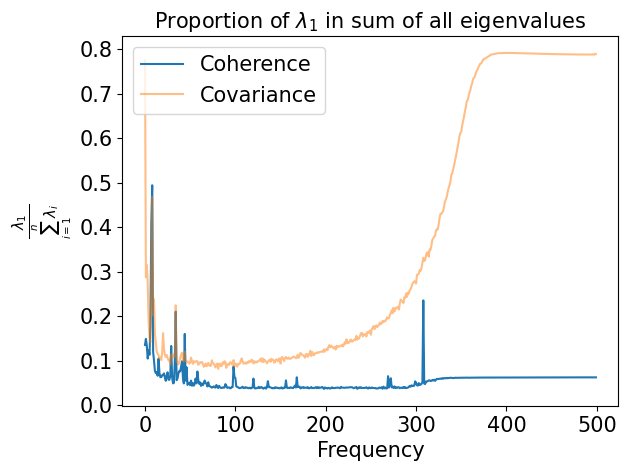

In [17]:
frequency_extent_ind = -1
plt.plot(
    frequencies[:frequency_extent_ind],
    eig_ratios_coherence_noise[:frequency_extent_ind],
    label="Coherence",
)
plt.plot(
    frequencies[:frequency_extent_ind],
    eig_ratios_covariance_noise[:frequency_extent_ind],
    label="Covariance",
    alpha=0.5,
)
plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$", fontsize=fsize)
plt.xlabel("Frequency", fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.title(
    "Proportion of $\lambda_1$ in sum of all eigenvalues", fontsize=fsize
)
plt.legend(fontsize=fsize)